### *CLIP Studies @ IAAC / Research & Method Masterclass - December 2023*
#**WHAT - Open Vocabulary object-detection with OWL-ViT**
*Iacopo Neri (iacopo.neri@uzh.ch) -- IAAC Faculty & MaCT Computational Lead (Spain) // Digital Visual Studies, University of Zurich (Switzerland)*

*Darìo Negueruela del Castillo (iacopo.neri@uzh.ch) -- Digital Visual Studies, University of Zurich (Switzerland)*

The following script takes extensive inspiration from the original [OWL-ViT-inference example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb)

# Import libraries

In [9]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install Pillow
!pip install matplotlib
!pip install opencv-python
!pip install opencv-python
!pip install scikit-image
!pip install numpy
!pip install requests

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     -------------------------------- ----- 51.2/60.6 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 60.6/60.6 kB 645.4 kB/s eta 0:00:00
  Using cached imageio-2.34.1-py3-none-any.whl.metadata (4.9 kB)
  Using cached tifffile-2024.5.22-py3-none-any.whl.metadata (30 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.2/12.8 MB 5.9 MB/s eta 0:00:03
   - -------------------------------------- 0.6/12.8 MB 7.0 MB/s eta 0:00:02
   ------ --------------------------------- 2.0/12.8 MB 17.9 MB/s eta 0:00:01
   --------- ------------------------------ 3.2/12.8 MB 22.5 MB/s eta 0:00:01
   -------------- ------------------------- 

In [4]:
pip install torch torchvision

  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 0.2/159.7 MB 5.8 MB/s eta 0:00:28
   ---------------------------------------- 1.3/159.7 MB 20.2 MB/s eta 0:00:08
    --------------------------------------- 2.5/159.7 MB 26.9 MB/s eta 0:00:06
   - -------------------------------------- 4.8/159.7 MB 34.1 MB/s eta 0:00:05
   - -------------------------------------- 6.2/159.7 MB 35.8 MB/s eta 0:00:05
   - -------------------------------------- 7.5/159.7 MB 36.8 MB/s eta 0:00:05
   -- ------------------------------------- 9.1/159.7 MB 36.3 MB/s eta 0:00:05
   -- ------------------------------------- 9.9/159.7 MB 35.2 MB/s eta 0:00:05
   -- ------------------------------------- 11.5/159.7 MB 38.6 MB/s eta 0:00:04
   --- ------------------------------------ 12.9/159.7 MB 43.5 MB/s eta 0:00:04
   --- -----

In [2]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
import cv2
import skimage
import numpy as np
from PIL import Image
import requests
from io import BytesIO

In [4]:
import matplotlib.pyplot as plt
from transformers.image_utils import ImageFeatureExtractionMixin

c:\Users\Siddharth\anaconda3\envs\iob_lagos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Model

In [5]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

# General functions

In [6]:
def run_predictions(model, text_queries, image):
  # Process image and text inputs
  inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

  # Set model in evaluation mode
  model = model.to(device)
  model.eval()

  # Get predictions
  with torch.no_grad():
    outputs = model(**inputs)

  return outputs

def get_results(model, image, outputs):
  mixin = ImageFeatureExtractionMixin()

  # Load example image
  image_size = model.config.vision_config.image_size
  image = mixin.resize(image, image_size)
  input_image = np.asarray(image).astype(np.float32) / 255.0

  # Get prediction logits
  logits = torch.max(outputs["logits"][0], dim=-1)
  scores = torch.sigmoid(logits.values).cpu().detach().numpy()

  # Get prediction labels and boundary boxes
  labels = logits.indices.cpu().detach().numpy()
  boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

  return input_image, labels, boxes, scores


def plot_predictions(input_image, text_queries, scores, boxes, labels, threshold):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })



# Object Detection

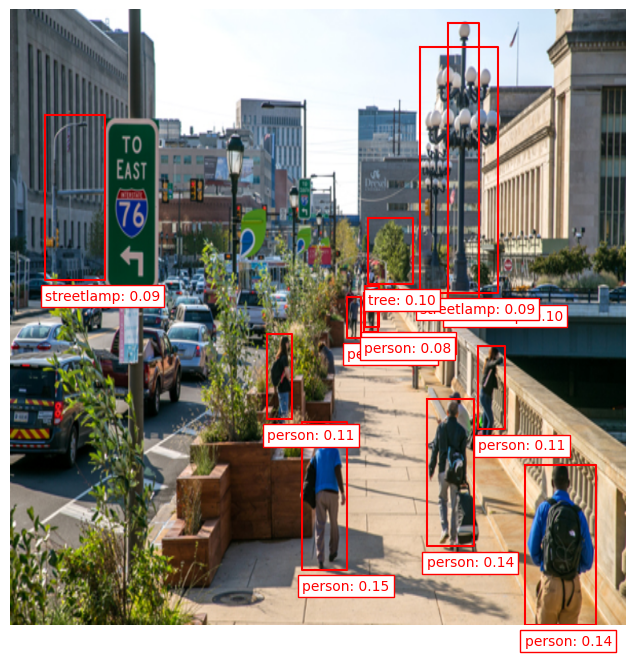

In [7]:
#@title Settings 🔬🎨

url = "https://www.universitycity.org/sites/default/files/Market_Street_Bridge-2.jpg" #@param {type:"string"}

#@markdown _to separate labels use_ /

input_lbls = "person/tree/signal/streetlamp" #@param {type:"string"}
#@markdown _reduce the threshold for less confident detections_

threshold = 0.08 #@param {type:"number"}


# Import data
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Preprocess inputs
text_queries = input_lbls.split("/")

# Run Prediction
outputs = run_predictions(model, text_queries, image)

# # Plot result
input_image, labels, boxes, scores = get_results(model, image, outputs)
plot_predictions(input_image, text_queries, scores, boxes, labels, threshold)

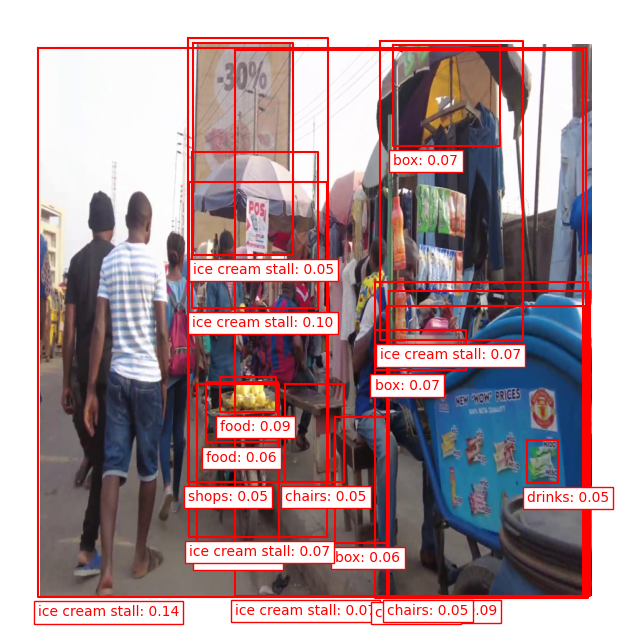

In [26]:
from PIL import Image

file_path = "C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Frames_YABA Market - Lagos, Nigeria/frame_3.jpg"

# Open the image without resizing
image = Image.open(file_path)
image.load()  # This is important to load the image data

# Get the original size of the image
width, height = image.size

#@markdown _to separate labels use_ /

input_lbls = "drinks/ice cream stall/food/wood/fish/meat/railway tracks/chairs/vegetables/vehicles/box/bridge/handbags/shops" #@param {type:"string"}
#@markdown _reduce the threshold for less confident detections_

threshold = 0.05 #@param {type:"number"}

# Preprocess inputs
text_queries = input_lbls.split("/")

# Run Prediction
outputs = run_predictions(model, text_queries, image)

# # Plot result
input_image, labels, boxes, scores = get_results(model, image, outputs)
plot_predictions(input_image, text_queries, scores, boxes, labels, threshold)

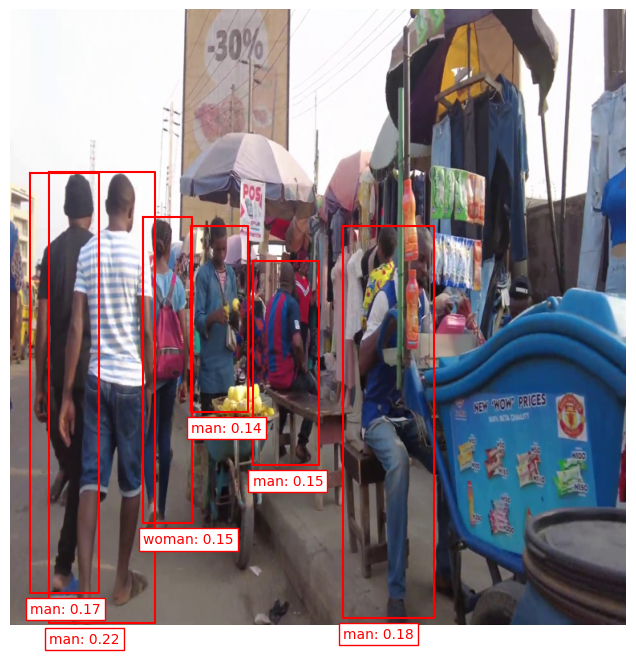

In [31]:
from PIL import Image

file_path = "C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Frames_YABA Market - Lagos, Nigeria/frame_3.jpg"

# Open the image without resizing
image = Image.open(file_path)
image.load()  # This is important to load the image data

# Get the original size of the image
width, height = image.size

#@markdown _to separate labels use_ /

input_lbls = "man/woman" #@param {type:"string"}
#@markdown _reduce the threshold for less confident detections_

threshold = 0.1 #@param {type:"number"}

# Preprocess inputs
text_queries = input_lbls.split("/")

# Run Prediction
outputs = run_predictions(model, text_queries, image)

# # Plot result
input_image, labels, boxes, scores = get_results(model, image, outputs)
plot_predictions(input_image, text_queries, scores, boxes, labels, threshold)

Processed image frame_1.jpg and saved output to C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames\output_frame_1.jpg
Processed image frame_10.jpg and saved output to C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames\output_frame_10.jpg
Processed image frame_11.jpg and saved output to C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames\output_frame_11.jpg
Processed image frame_12.jpg and saved output to C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames\output_frame_12.jpg
Processed image frame_13.jpg and saved output to C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames\output_frame_13.jpg
Processed image frame_14.jpg and saved output to C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames\output_frame_14.jpg
Processed image frame_15.jpg and saved output to C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames\output_frame_15.jpg
Processed image

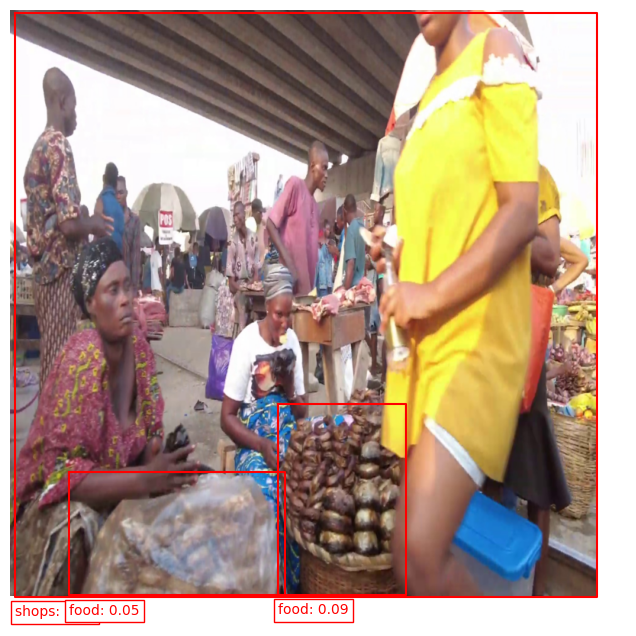

In [51]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define the input and output folder paths
input_folder_path = "C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Frames_YABA Market - Lagos, Nigeria"
output_folder_path = "C:/Users/Siddharth/JupyterFiles_Python/IOB_Lagos/Gendered_Output_Frames"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

#@markdown _to separate labels use_ /

input_lbls = "bottles/stalls/food/wood/fish/meat/railway/chairs/vegetables/vehicles/box/bridge/handbags/shops/umbrella" #@param {type:"string"}
#@markdown _reduce the threshold for less confident detections_

threshold = 0.05 #@param {type:"number"}

# Loop through all the image files in the input folder
for filename in os.listdir(input_folder_path):
    if filename.endswith(".jpg"):  # or.png,.jpeg, etc. depending on your image format
        file_path = os.path.join(input_folder_path, filename)
        
        # Open the image without resizing
        image = Image.open(file_path)
        image.load()  # This is important to load the image data

        # Get the original size of the image
        width, height = image.size

        # Preprocess inputs
        text_queries = input_lbls.split("/")

        # Run Prediction
        outputs = run_predictions(model, text_queries, image)

        # Get the results
        input_image, labels, boxes, scores = get_results(model, image, outputs)

        # Plot result
        plt.close()  # close the previous figure to avoid memory leaks
        plot_predictions(input_image, text_queries, scores, boxes, labels, threshold)

        # Save the plot to a file
        output_file_path = os.path.join(output_folder_path, f"output_{filename}")
        plt.savefig(output_file_path)

        print(f"Processed image {filename} and saved output to {output_file_path}")